In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
from spynal.spikes import density
import sys

sys.path.append('../..')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

plt.style.use('../../sci_style.py')

# Load Data

In [3]:
session = 'Mary-Anesthesia-20160912-02'
# session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160826-02'
# session = 'MrJones-Anesthesia-20160107-01'
# session = 'Mary-Anesthesia-20160822-02'
# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160121-01'
# session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160105-01'

# session_list = ['Mary-Anesthesia-20160912-02',
# 'MrJones-Anesthesia-20160109-01',
# 'Mary-Anesthesia-20160826-02',
# 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False

results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

# Load Data

In [4]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

In [9]:
# area_spike_dict = {}
# for area in np.hstack([session_info['areas']]):
#     print(area)
#     if area == 'all':
#         unit_inds = np.arange(len(unit_info['area']))
#     else:
#         unit_inds = np.where(unit_info['area'] == area)[0]
#     area_spike_dict[area] = np.zeros((len(unit_inds), T))
#     for i, ind in enumerate(unit_inds):
#         unit_spike_times = spike_times[ind]
#         for t in unit_spike_times:
#             area_spike_dict[area][i, int(t/dt)] = 1
# up_down_dict = get_up_down(area_spike_dict, bin_size=200)

# Prediction

In [10]:
width = 0.1 # s
step = 0.1 # s
dt_rate = step

In [11]:
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [12]:
# rates = None
# for i in tqdm(range(len(unit_indices))):
#     unit_rates, _ = density(spike_times[i], lims=[0, (lfp.shape[0] - 1)*dt], width=width, step=step)
#     if rates is None:
#         rates = np.zeros((len(unit_rates), len(unit_indices)))
#     rates[:, i] = unit_rates

In [13]:
start_wake = 100 # s
start_anesthesia = session_info['drugStart'][1] # s
# window = 15 # s
# window_lfp = int(window/dt)
# window_rate = int(window/dt_rate)
window_lfp = 15000
window_rate = 15000
# T_pred = 5 # s
# T_pred_lfp = int(T_pred/dt)
# T_pred_rate = int(T_pred/dt_rate)
T_pred_lfp = 5000
T_pred_rate = 5000

# signal_wake_rate = np.copy(rates[int(start_wake/dt_rate):int(start_wake/dt_rate) + window_rate, unit_indices])
# signal_wake_rate -= signal_wake_rate.mean(axis=0)
# signal_anesthesia_rate = np.copy(rates[int(start_anesthesia/dt_rate):int(start_anesthesia/dt_rate) + window_rate, unit_indices])
# signal_anesthesia_rate -= signal_anesthesia_rate.mean(axis=0)

# signal_wake_rate_test = np.copy(rates[int(start_wake/dt_rate) + window_rate:int(start_wake/dt_rate) + window_rate + T_pred_rate, unit_indices])
# signal_wake_rate_test -= signal_wake_rate_test.mean(axis=0)
# signal_anesthesia_rate_test = np.copy(rates[int(start_anesthesia/dt_rate) + window_rate:int(start_anesthesia/dt_rate) + window_rate + T_pred_rate, unit_indices])
# signal_anesthesia_rate_test -= signal_anesthesia_rate_test.mean(axis=0)

signal_wake_lfp = np.copy(lfp[int(start_wake/dt):int(start_wake/dt) + window_lfp, unit_indices])
signal_wake_lfp -= signal_wake_lfp.mean(axis=0)
signal_anesthesia_lfp = np.copy(lfp[int(start_anesthesia/dt):int(start_anesthesia/dt) + window_lfp, unit_indices])
signal_anesthesia_lfp -= signal_anesthesia_lfp.mean(axis=0)

signal_wake_lfp_test = np.copy(lfp[int(start_wake/dt) + window_lfp:int(start_wake/dt) + window_lfp + T_pred_lfp, unit_indices])
signal_wake_lfp_test -= signal_wake_lfp_test.mean(axis=0)
signal_anesthesia_lfp_test = np.copy(lfp[int(start_anesthesia/dt) + window_lfp:int(start_anesthesia/dt) + window_lfp + T_pred_lfp, unit_indices])
signal_anesthesia_lfp_test -= signal_anesthesia_lfp_test.mean(axis=0)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
%%time
matrix_size = 750
r = 750

# delase_w_rate = DeLASE(signal_wake_rate + np.random.randn(*signal_wake_rate.shape)*0.0001, dt=dt_rate, matrix_size=matrix_size, use_torch=True, device='cpu')
delase_w_lfp = DeLASE(signal_wake_lfp, dt=dt, matrix_size=matrix_size, use_torch=True, device=device)

# delase_a_rate = DeLASE(signal_anesthesia_rate + np.random.randn(*signal_anesthesia_rate.shape)*0.001, dt=dt_rate, matrix_size=matrix_size, use_torch=True, device='cpu')
delase_a_lfp = DeLASE(signal_anesthesia_lfp, dt=dt, matrix_size=matrix_size, use_torch=True, device=device)

CPU times: user 1.55 s, sys: 636 ms, total: 2.18 s
Wall time: 4.27 s


In [16]:
# delase_w_rate.compute_havok_dmd(r=r)
delase_w_lfp.compute_havok_dmd(r=r)
# delase_a_rate.compute_havok_dmd(r=r)
delase_a_lfp.compute_havok_dmd(r=r)

In [32]:
reseeds = [30, 500, 5000]
predictions = []
for reseed in tqdm(reseeds):
    preds_w_lfp = delase_w_lfp.predict_havok_dmd(signal_wake_lfp_test, tail_bite=True, reseed=reseed).cpu()
    preds_a_lfp = delase_a_lfp.predict_havok_dmd(signal_anesthesia_lfp_test, tail_bite=True, reseed=reseed).cpu()
    predictions.append((preds_w_lfp, preds_a_lfp, reseed))

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
# true_color_wake = 'C0'
# pred_color_wake = 'orange'
true_color_wake = '#009ade' # blue
pred_color_wake = '#ffc61e' # yellow
true_color_anesthesia = '#af58ba' # purple
pred_color_anesthesia = '#00cd6c' # green

pred_linestyle = '-'

mode = 'anesthesia'

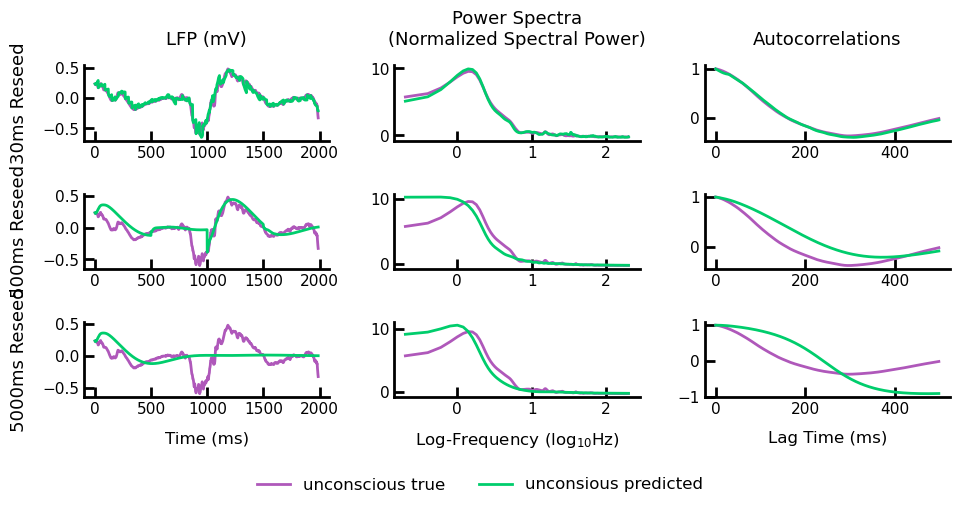

In [36]:
start_ind = 0
end_ind = 2000
legend_fontsize = 12
ylabel_fontsize=13
xlabel_fontsize=12
title_fontsize=13
p = delase_w_lfp.p
min_freq = 0.2
max_freq = 200
spectrum_smoothing_width = 0.5 # Hz
log_freqs = True
tick_fontsize=11

if mode == 'wake':
    true_color = true_color_wake
    pred_color = pred_color_wake
else:
    true_color = true_color_anesthesia
    pred_color = pred_color_anesthesia

index = 0


fig, axs = plt.subplots(len(reseeds), 3, sharex='col')

for i in range(len(reseeds)):
    ax = axs[i][0]
    if mode == 'wake':
        true_signal = signal_wake_lfp_test[start_ind:end_ind, index]
        pred_signal = predictions[i][0][start_ind:end_ind, index]
    else:
        true_signal = signal_anesthesia_lfp_test[start_ind:end_ind, index]
        pred_signal = predictions[i][1][start_ind:end_ind, index]
    ax.plot(true_signal[p:], label='true', c=true_color)
    ax.plot(pred_signal[p:], label='predicted', c=pred_color, linestyle=pred_linestyle)
    min_val = np.min([true_signal.min(), pred_signal.min()])
    max_val = np.max([true_signal.max(), pred_signal.max()])
#     if i == len(reseeds) - 1:
# #         draw_sizebar(ax, 100, '100 ms', size_vertical=0.0024)
# #         ax.legend(bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=legend_fontsize)
#         if mode == 'wake':
#             ax.plot([true_signal[p:].shape[0]*0.65, true_signal[p:].shape[0]*0.65 + 200], [min_val, min_val], c='k')
#             ax.text(true_signal[p:].shape[0]*0.65, min_val - np.abs(min_val)*0.4, "200 ms", fontsize=12)
#         else:
#             ax.plot([true_signal[p:].shape[0]*0.65, true_signal[p:].shape[0]*0.65 + 200], [min_val, min_val], c='k')
#             ax.text(true_signal[p:].shape[0]*0.65, min_val - np.abs(min_val)*0.3, "200 ms", fontsize=12)
            #     if i == 0:
#         loc = true_signal[p:].shape[0]
#         ax.plot([loc, loc], [max_val - 0.1, max_val], c='k')
#         ax.text(loc*1.01, max_val -0.1/2, r"100 $\mu V$", fontsize=12)
        

    # ax.spines[['right', 'top']].set_visible(False)
    # ax.get_xaxis().tick_bottom()
    # ax.get_yaxis().tick_left()
#     ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.set_ylabel(f"{predictions[i][2]}ms Reseed", fontsize=ylabel_fontsize)
#     ax.set_xticks([])
#     ax.set_yticks([])

    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax.tick_params(labelsize=tick_fontsize)
    
    if i == 0:
        ax.set_title('LFP (mV)', fontsize=title_fontsize)
    if i == len(reseeds) -1:
        ax.set_xlabel('Time (ms)', fontsize=xlabel_fontsize)
        
    
    ax = axs[i][1]
    
    if mode == 'wake':
        true_fft = np.fft.rfft(signal_wake_lfp_test.T)
        pred_fft = np.fft.rfft(predictions[i][0].T)
        freqs = np.fft.rfftfreq(signal_wake_lfp_test.shape[0], dt)
    else:
        true_fft = np.fft.rfft(signal_anesthesia_lfp_test.T)
        pred_fft = np.fft.rfft(predictions[i][1].T)
        freqs = np.fft.rfftfreq(signal_anesthesia_lfp_test.shape[0], dt)
    freq_inds = np.logical_and(freqs >= min_freq, freqs <= max_freq)
    
    df = freqs[1]
    spectrum_true = scipy.ndimage.gaussian_filter1d(np.abs(true_fft[index][freq_inds]), spectrum_smoothing_width/df)
    spectrum_pred = scipy.ndimage.gaussian_filter1d(np.abs(pred_fft[index][freq_inds]), spectrum_smoothing_width/df)
    spectrum_true = (spectrum_true - spectrum_true.mean())/spectrum_true.std()
    spectrum_pred = (spectrum_pred - spectrum_pred.mean())/spectrum_pred.std()
#     print(scipy.stats.pearsonr(spectrum_true, spectrum_pred))

    min_val = np.min([spectrum_true.min(), spectrum_pred.min()])
    max_val = np.max([spectrum_true.max(), spectrum_pred.max()])
    
    if log_freqs:
        log_func = lambda x: np.log10(x)
    else:
        log_func = lambda x: x
    
    ax.plot(log_func(freqs[freq_inds]), spectrum_true, c=true_color)
    ax.plot(log_func(freqs[freq_inds]), spectrum_pred, c=pred_color, linestyle=pred_linestyle)
    
#     if i == len(reseeds) - 1:
#         loc = freqs[freq_inds][-1]*0.65
#         if mode == 'wake':
#             ax.plot([log_func(loc), log_func(loc + 20)], [min_val-1, min_val-1], c='k')
#             ax.text(log_func(loc), min_val - 2.5, "20 Hz", fontsize=12)
#         else:
#             ax.plot([log_func(loc), log_func(loc + 20)], [min_val-0.5, min_val-0.5], c='k')
#             ax.text(log_func(loc), min_val - 2.2, "20 Hz", fontsize=12)
    
#     if i == 0:
#         loc = true_signal[p:].shape[0]
#         ax.plot([loc, loc], [max_val - 0.1, max_val], c='k')
#         ax.text(loc*1.01, max_val -0.1/2, r"100 $\mu V$", fontsize=12)
    
#     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax.tick_params(labelsize=tick_fontsize)
    
    if i == 0:
        ax.set_title('Power Spectra\n(Normalized Spectral Power)', fontsize=title_fontsize)
    if i == len(reseeds) -1:
        ax.set_xlabel(('Log-' if log_freqs else '') + 'Frequency ' + (r'($\log_{10}$Hz)' if log_freqs else "(Hz)"), fontsize=xlabel_fontsize)
    
    ax = axs[i][2]
    
    if mode == 'wake':
        true_correl = get_autocorrel_funcs(signal_wake_lfp_test[:, [index]])[0]
        pred_correl = get_autocorrel_funcs(predictions[i][0][:, [index]])[0]
    else:
        true_correl = get_autocorrel_funcs(signal_anesthesia_lfp_test[:, [index]])[0]
        pred_correl = get_autocorrel_funcs(predictions[i][1][:, [index]])[0]
    
    ax.plot(true_correl, c=true_color)
    ax.plot(pred_correl, c=pred_color, linestyle=pred_linestyle)
    
#     
    
    if i == 0:
        ax.set_title('Autocorrelations', fontsize=title_fontsize)
    if i == len(reseeds) -1:
        ax.set_xlabel('Lag Time (ms)', fontsize=xlabel_fontsize)
        
    min_val = np.min([true_correl.min(), pred_correl.min()])
    max_val = np.max([true_correl.max(), pred_correl.max()])
        
#     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     if i == len(reseeds) - 1:
#         loc = true_correl.shape[0]*0.65
#         if mode == 'wake':
#             ax.plot([loc, loc + 50], [min_val, min_val], c='k')
#             ax.text(loc, min_val - 0.2, "50 ms", fontsize=12)
#         else:
#             ax.plot([loc, loc + 50], [min_val - 0.05, min_val - 0.05], c='k')
#             ax.text(loc, min_val - 0.3, "50 ms", fontsize=12)

    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax.tick_params(labelsize=tick_fontsize)
    
if mode == 'wake':
    lns = []
    lns += plt.plot([], label='awake true', c=true_color_wake)
    lns += plt.plot([], label='awake predicted', c=pred_color_wake, linestyle=pred_linestyle)
    labs = [ln.get_label() for ln in lns]
    fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.01), ncol=2, loc='center', fontsize=legend_fontsize)
else:
    lns = []
    lns += plt.plot([], label='unconscious true', c=true_color_anesthesia)
    lns += plt.plot([], label='unconsious predicted', c=pred_color_anesthesia,  linestyle=pred_linestyle)
    labs = [ln.get_label() for ln in lns]
    fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.01), ncol=2, loc='center', fontsize=legend_fontsize)
    
    
plt.tight_layout()
plt.show()

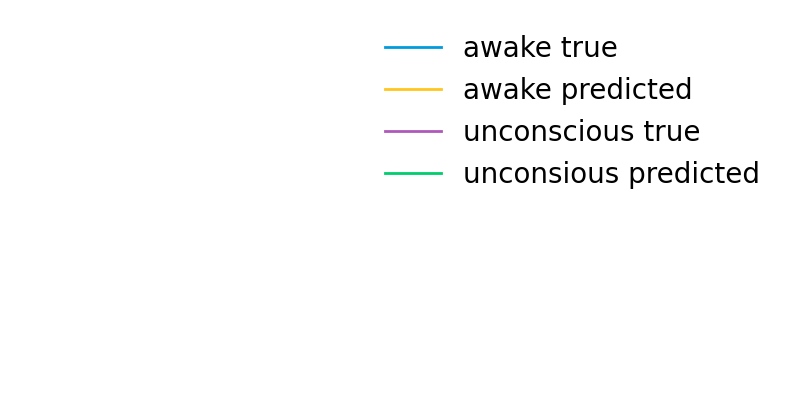

In [217]:
plt.plot([], label='awake true', c=true_color_wake)
plt.plot([], label='awake predicted', c=pred_color_wake)
plt.plot([], label='unconscious true', c=true_color_anesthesia, linestyle=pred_linestyle)
plt.plot([], label='unconsious predicted', c=pred_color_anesthesia, linestyle=pred_linestyle)
ax = plt.gca()
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.legend(bbox_to_anchor=(0, 0, 1, 1))
plt.show()

# Sample Data

## Get Data

In [218]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [219]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [220]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [221]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [222]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

## Plot

In [63]:
start_anesthesia = session_info['drugStart'][1] - 498

In [64]:
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}

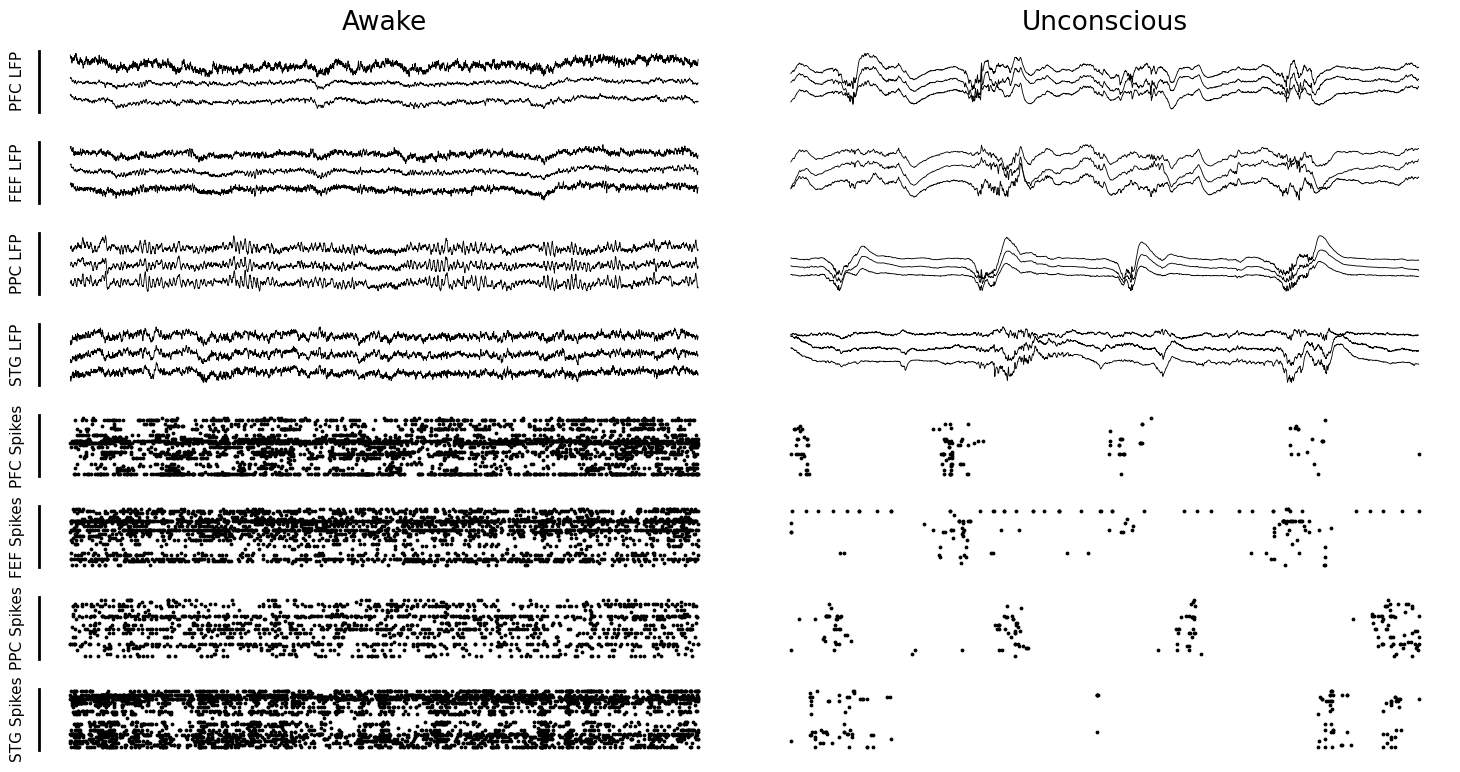

In [65]:
fig, axs = plt.subplots(8, 2, figsize=(15, 8))

ylabel_fontsize = 11
title_fontsize = 19

areas = ['vlPFC', 'FEF', '7b', 'CPB']

for j, area in enumerate(areas):
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]

    ax = axs[j][0]
    inds = np.random.choice(unit_indices, size=(3,), replace=False)
    for n, ind in enumerate(inds):
        ax.plot(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind] - n*0.3, c='k', linewidth=0.6)
    
    ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylabel(f"{area_labels[area]} LFP", fontsize=ylabel_fontsize)
    
    if j == 0:
        ax.set_title('Awake', fontsize=title_fontsize)
    
    ax = axs[j][1]
    inds = np.random.choice(unit_indices, size=(3,), replace=False)
    for n, ind in enumerate(inds):
        ax.plot(lfp[int(start_anesthesia/dt):int((start_anesthesia + 10)/dt), ind] - n*0.3, c='k', linewidth=0.6)
    
    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if j == 0:
        ax.set_title('Unconscious', fontsize=title_fontsize)
    
    ax = axs[j + 4][0]
    ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylabel(f"{area_labels[area]} Spikes", fontsize=ylabel_fontsize, rotation='90')
    
    if area == 'all':
        unit_indices = np.arange(len(unit_info['area']))
    else:
        unit_indices = np.where(unit_info['area'] == area)[0]
    unit_indices = np.random.choice(unit_indices, size=(30,), replace=False)
    
    for n, unit_ind in enumerate(unit_indices):
        spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_wake, spike_times[unit_ind] <= start_wake + 10)]
        spike_ts = (spike_ts - start_wake)/dt
        ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)

    ax = axs[j + 4][1]
    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    for n, unit_ind in enumerate(unit_indices):
        spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_anesthesia, spike_times[unit_ind] <= start_anesthesia + 10)]
        spike_ts = (spike_ts - start_wake)/dt
        ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)
    
plt.tight_layout()
plt.show()

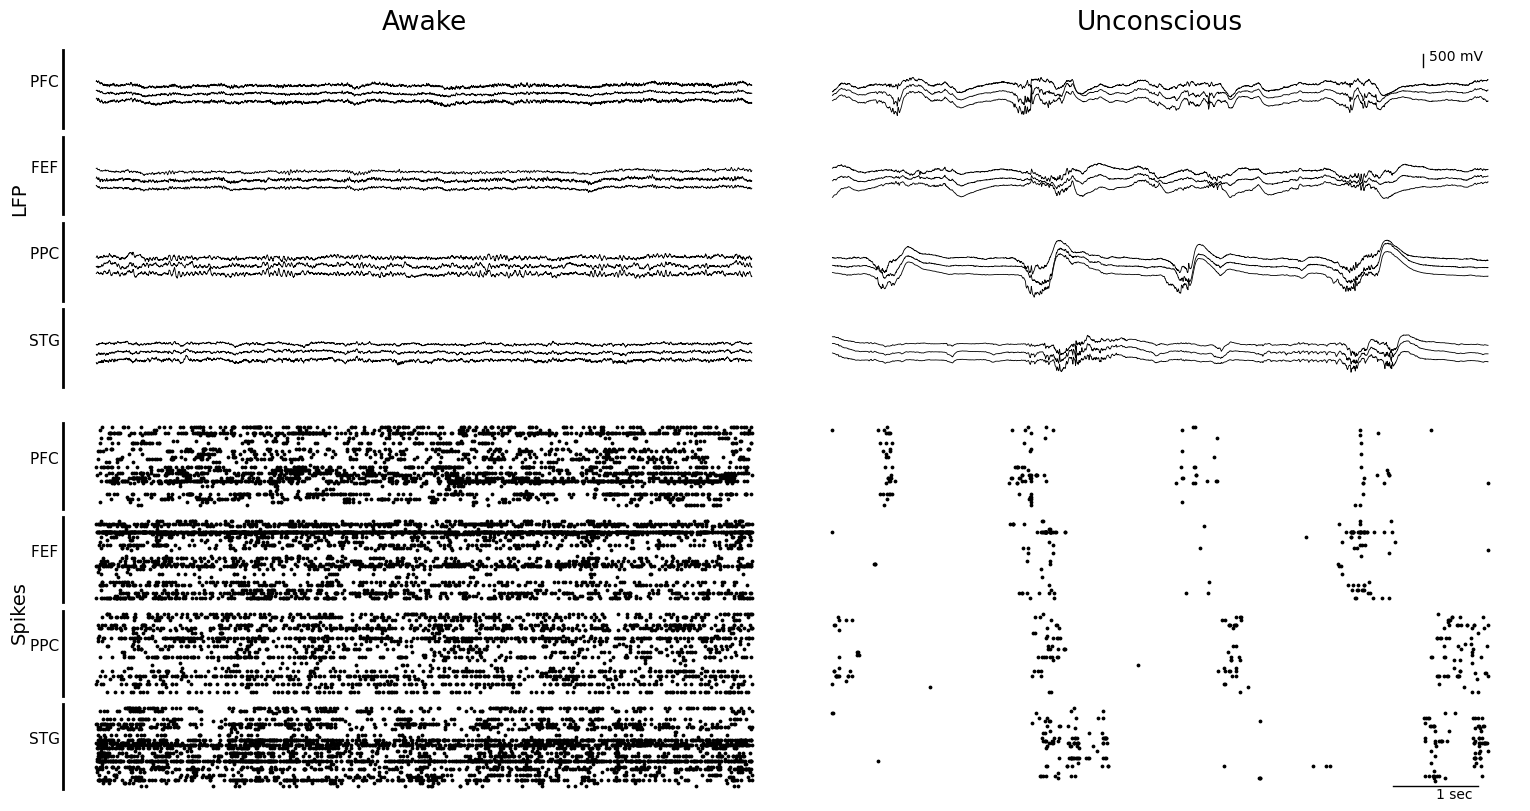

In [112]:
fig = plt.figure(layout='constrained', figsize=(15, 8))
subfigs = fig.subfigures(2, 1, hspace=0.07)

ylabel_fontsize = 11
superylabel_fontsize = 14
title_fontsize = 19

areas = ['vlPFC', 'FEF', '7b', 'CPB']
axs = subfigs[0].subplots(4, 2, sharey=True)
for j, area in enumerate(areas):
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]

    ax = axs[j][0]
    inds = np.random.choice(unit_indices, size=(3,), replace=False)
    for n, ind in enumerate(inds):
        ax.plot(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind] - n*0.3, c='k', linewidth=0.6)
    
    ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylabel(f"{area_labels[area]}  ", fontsize=ylabel_fontsize, rotation=0)
    
    if j == 0:
        ax.set_title('Awake', fontsize=title_fontsize)
    
    ax = axs[j][1]
    inds = np.random.choice(unit_indices, size=(3,), replace=False)
    for n, ind in enumerate(inds):
        ax.plot(lfp[int(start_anesthesia/dt):int((start_anesthesia + 10)/dt), ind] - n*0.3, c='k', linewidth=0.6)
    
    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if j == 0:
        ax.set_title('Unconscious', fontsize=title_fontsize)
        max_val = lfp[int(start_wake/dt):int((start_wake + 10)/dt), inds[-1]].max()
        bar_verts = [max_val + 0.5, max_val + 1]
        ax.plot([int(10/dt)*0.9, int(10/dt)*0.9], bar_verts, c='k', linewidth=1)
        ax.text(int(10/dt)*0.91, np.mean(bar_verts), "500 mV", fontsize=10)
subfigs[0].text(-0.01, 0.5, "LFP", va='center', fontsize=superylabel_fontsize, rotation=90)

axs = subfigs[1].subplots(4, 2)
for j, area in enumerate(areas):
    ax = axs[j][0]
    ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylabel(f"{area_labels[area]}  ", fontsize=ylabel_fontsize, rotation=0)
    
    if area == 'all':
        unit_indices = np.arange(len(unit_info['area']))
    else:
        unit_indices = np.where(unit_info['area'] == area)[0]
    unit_indices = np.random.choice(unit_indices, size=(30,), replace=False)
    
    for n, unit_ind in enumerate(unit_indices):
        spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_wake, spike_times[unit_ind] <= start_wake + 10)]
        spike_ts = (spike_ts - start_wake)/dt
        ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)

    ax = axs[j][1]
    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    for n, unit_ind in enumerate(unit_indices):
        spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_anesthesia, spike_times[unit_ind] <= start_anesthesia + 10)]
        spike_ts = (spike_ts - start_wake)/dt
        ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)
    
    xmax = ax.get_xlim()[1]
    ymin = ax.get_ylim()[0]
    if j == 3:
#         ax.set_title('Unconscious', fontsize=title_fontsize)
#         bar_verts = [max_val + 0.5, max_val + 1]
        ax.plot([xmax - 10000*0.15, xmax - 10000*0.05], [-2, -2], c='k', linewidth=1)
        ax.text(xmax - 10000*0.1, -7, "1 sec", fontsize=10)
    
subfigs[1].text(-0.01, 0.5, "Spikes", va='center', fontsize=superylabel_fontsize, rotation=90)
# plt.tight_layout()
plt.show()

# Plot 3 integrated performance

In [37]:
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/performance_results'

In [38]:
session_rets_performance = {}
norm_folder = 'NOT_NORMED'
for session in os.listdir(results_dir):
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    session_rets_performance[session] = {}
    
    # ---------------------------------
    # LOAD DATA
    # --------------------------------
    print("loading data...")
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

    section_times = dict( 
            wake=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugEnd'][1]),
            recovery=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    
    session_rets_performance[session]['electrode_info'] = electrode_info
    session_rets_performance[session]['session_info'] = session_info
    session_rets_performance[session]['eyes_open'] = eyes_open
    session_rets_performance[session]['eyes_close'] = eyes_close
    session_rets_performance[session]['section_times'] = section_times
    session_rets_performance[session]['sections'] = sections
    session_rets_performance[session]['results_dict'] = {}
    
    num_its = 0
    for area in os.listdir(os.path.join(results_dir, session, norm_folder)):
        num_its += len(os.listdir(os.path.join(results_dir, session, norm_folder, area)))
    iterator = tqdm(total=num_its)
    for area in os.listdir(os.path.join(results_dir, session, norm_folder)):
        session_rets_performance[session]['results_dict'][area] = None
        for f in os.listdir(os.path.join(results_dir, session, norm_folder, area)):
            t, window = float(f.split('_')[0]), int(f.split('_')[2])
            df = pd.DataFrame(pd.read_pickle(os.path.join(results_dir, session, norm_folder, area, f)))
            df['start_time'] = t
            df['end_time'] = t + window*dt
            
            if session_rets_performance[session]['results_dict'][area] is None:
                session_rets_performance[session]['results_dict'][area] = df
            else:
                session_rets_performance[session]['results_dict'][area] = pd.concat([session_rets_performance[session]['results_dict'][area], df])
                
            iterator.update()
    iterator.close()

------------------------------
SESSION = MrJones-Anesthesia-20160301-01
------------------------------
loading data...


  0%|          | 0/3300 [00:00<?, ?it/s]

------------------------------
SESSION = Mary-Anesthesia-20160908-02
------------------------------
loading data...


  0%|          | 0/2210 [00:00<?, ?it/s]

In [198]:
split_by_monkey = True

performance_rets = {}
counts = {}

if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
else:
    monkeys = ['Combined']

# areas = ['vlPFC', 'FEF', '7b', 'CPB']
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

for monkey in monkeys:
    performance_rets[monkey] = {}
    counts[monkey] = {}
    
    for area in areas:
        performance_rets[monkey][area] = {}
        counts[monkey][area] = {}
        
        performance_rets[monkey][area]['ip'] = 0
        performance_rets[monkey][area]['reseed_performance_curve'] = 0
        performance_rets[monkey][area]['reseed_autocorrel_correl'] = 0
        performance_rets[monkey][area]['reseed_fft_correl'] = 0
        
        counts[monkey][area] = 0
        
        for session in sessions:
            if not split_by_monkey or monkey in session:
                performance_rets[monkey][area]['ip'] += session_rets_performance[session]['results_dict'][area].ip.sum()
                
                performance_rets[monkey][area]['reseed_performance_curve'] += session_rets_performance[session]['results_dict'][area].performance_curve.sum()
                performance_rets[monkey][area]['reseed_autocorrel_correl'] += session_rets_performance[session]['results_dict'][area].all_metric_vals.apply(lambda x: np.array([d['autocorrel_correl'] for d in x])).sum()
                performance_rets[monkey][area]['reseed_fft_correl'] += session_rets_performance[session]['results_dict'][area].all_metric_vals.apply(lambda x: np.array([d['fft_correl'] for d in x])).sum()
                
                counts[monkey][area] += len(session_rets_performance[session]['results_dict'][area])
        
        for metric in ['ip', 'reseed_performance_curve', 'reseed_autocorrel_correl', 'reseed_fft_correl']:
            performance_rets[monkey][area][metric] /= counts[monkey][area]

In [199]:
reseed_vals = session_rets_performance[session]['results_dict'][area].reseed_vals.iloc[0]

In [200]:
performance_rets_se = {}
se_counts = {}

for monkey in monkeys:
    performance_rets_se[monkey] = {}
    se_counts[monkey] = {}
    
    for area in areas:
        performance_rets_se[monkey][area] = {}
        se_counts[monkey][area] = {}
        
        performance_rets_se[monkey][area]['ip'] = 0
        performance_rets_se[monkey][area]['reseed_performance_curve'] = 0
        performance_rets_se[monkey][area]['reseed_autocorrel_correl'] = 0
        performance_rets_se[monkey][area]['reseed_fft_correl'] = 0
        
        se_counts[monkey][area] = 0
        
        for session in sessions:
            if not split_by_monkey or monkey in session:
                performance_rets_se[monkey][area]['ip'] += ((session_rets_performance[session]['results_dict'][area].ip - performance_rets[monkey][area]['ip'])**2).sum()
                
                performance_rets_se[monkey][area]['reseed_performance_curve'] += session_rets_performance[session]['results_dict'][area].performance_curve.apply(lambda x: (x - performance_rets[monkey][area]['reseed_performance_curve'])**2).sum()
                performance_rets_se[monkey][area]['reseed_autocorrel_correl'] += session_rets_performance[session]['results_dict'][area].all_metric_vals.apply(lambda x: (np.array([d['autocorrel_correl'] for d in x]) - performance_rets[monkey][area]['reseed_autocorrel_correl'])**2).sum()
                performance_rets_se[monkey][area]['reseed_fft_correl'] += session_rets_performance[session]['results_dict'][area].all_metric_vals.apply(lambda x: (np.array([d['fft_correl'] for d in x]) - performance_rets[monkey][area]['reseed_fft_correl'])**2).sum()
                
                se_counts[monkey][area] += len(session_rets_performance[session]['results_dict'][area])
        
        for metric in ['ip', 'reseed_performance_curve', 'reseed_autocorrel_correl', 'reseed_fft_correl']:
            performance_rets_se[monkey][area][metric] /= se_counts[monkey][area]
            performance_rets_se[monkey][area][metric] = np.sqrt(performance_rets_se[monkey][area][metric])
            performance_rets_se[monkey][area][metric] /= np.sqrt(se_counts[monkey][area])

In [201]:
area_colors = {
    'vlPFC': 'C0',
    'FEF': 'skyblue',
    '7b': 'slategray',
    'CPB': 'lightsteelblue', 
    'all': 'purple'
}
# area_colors = {
#     'vlPFC': palette2[0], 
#     'FEF': palette2[2],
#     '7b': palette2[3],
#     'CPB': palette2[4]
# }
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

In [202]:
reseed_vals

array([   1,    5,   10,   15,   20,   30,   40,   50,  100,  150,  200,
        250,  300,  400,  500,  750, 1000])

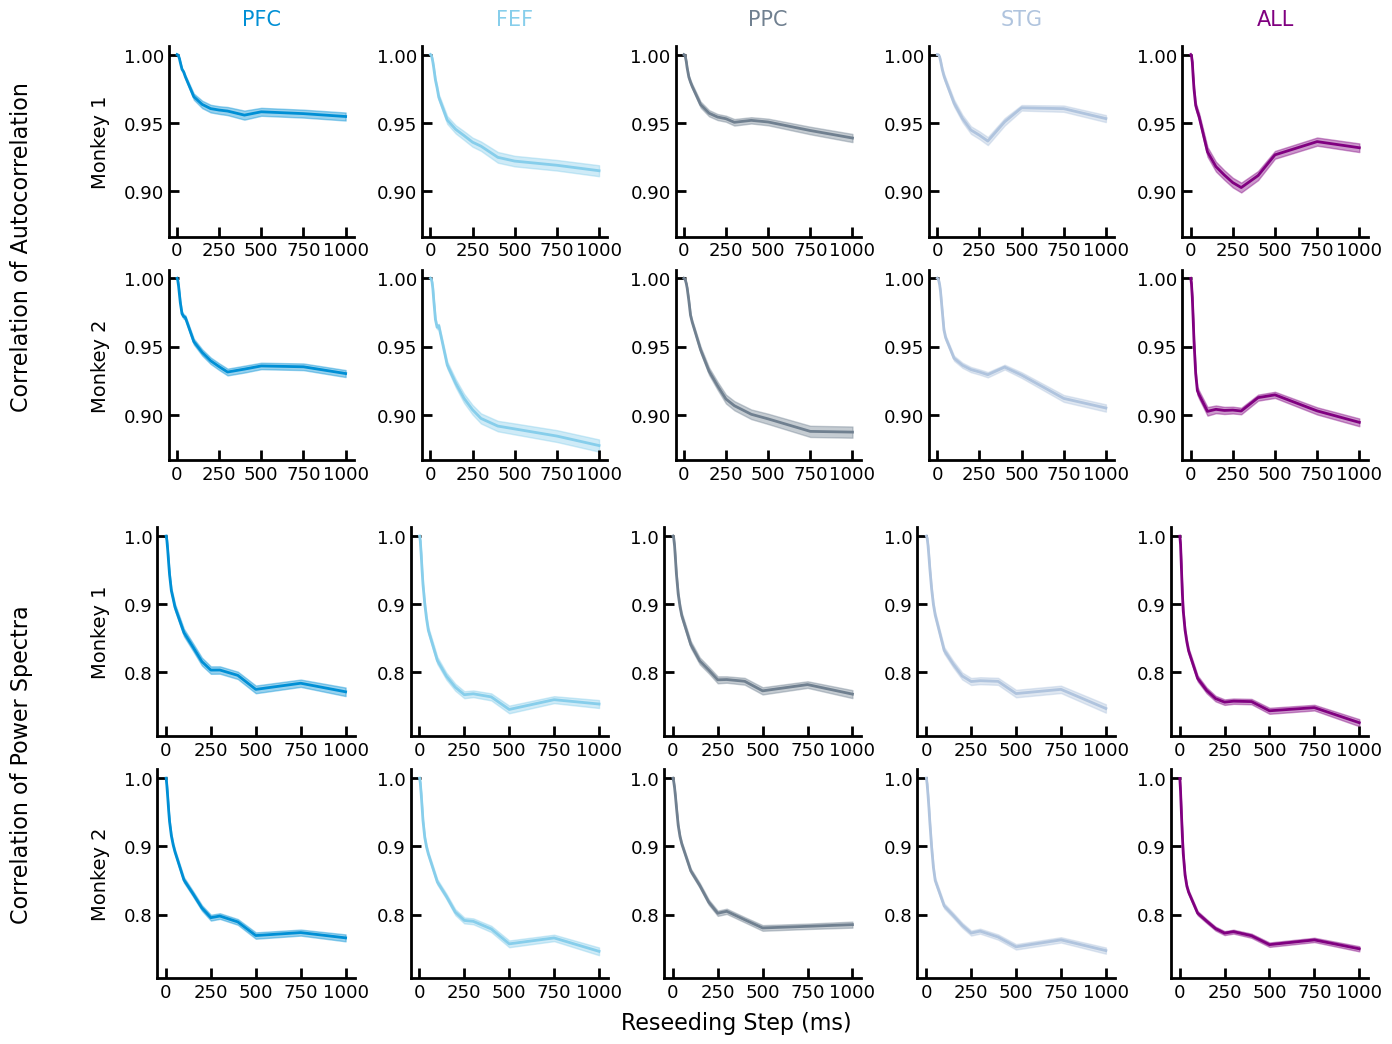

In [203]:
max_reseed = 1000
num_xticks=5
# max_reseed=30
# num_xticks=4
filter_inds = reseed_vals <= max_reseed
title_fontsize = 15
tick_fontsize = 13
xlabel_fontsize=16
ylabel_fontsize=16

bar = False
bar_width=5

fig = plt.figure(layout='constrained', figsize=(13, 10))
subfigs = fig.subfigures(2, 1, hspace=0.07)

axs = subfigs[0].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        if bar:
            ax.bar(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_autocorrel_correl'][filter_inds], color=area_colors[area], yerr=performance_rets_se[monkey][area]['reseed_autocorrel_correl'][filter_inds], width=bar_width)
        else:
#             ax.plot(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_autocorrel_correl'][filter_inds], color=area_colors[area])
#             lower_bound = performance_rets[monkey][area]['reseed_autocorrel_correl'] - performance_rets_se[monkey][area]['reseed_autocorrel_correl']
#             upper_bound = performance_rets[monkey][area]['reseed_autocorrel_correl'] + performance_rets_se[monkey][area]['reseed_autocorrel_correl']
#             ax.fill_between(reseed_vals[filter_inds], lower_bound[filter_inds], upper_bound[filter_inds], alpha=0.4, color=area_colors[area])
            ax.scatter(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_autocorrel_correl'][filter_inds], color=area_colors[area])
#             lower_bound = performance_rets[monkey][area]['reseed_autocorrel_correl'] - performance_rets_se[monkey][area]['reseed_autocorrel_correl']
#             upper_bound = performance_rets[monkey][area]['reseed_autocorrel_correl'] + performance_rets_se[monkey][area]['reseed_autocorrel_correl']
#             ax.fill_between(reseed_vals[filter_inds], lower_bound[filter_inds], upper_bound[filter_inds], alpha=0.4, color=area_colors[area])

        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if i == 0:
            ax.set_title(area_labels[area], color=area_colors[area], fontsize=title_fontsize)
            
        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)
        
        xticks = [int(d) for d in np.linspace(0, max_reseed, num_xticks)]
        ax.set_xticks(xticks)
        ax.tick_params(labelsize=tick_fontsize)

# subfigs[0].text(0.5, -0.01, 'Reseeding Step (ms)', ha='center', fontsize=xlabel_fontsize)
subfigs[0].text(-0.05, 0.5, 'Correlation of Autocorrelation', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)

axs = subfigs[1].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        if bar:
            ax.bar(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_fft_correl'][filter_inds], color=area_colors[area], yerr=performance_rets_se[monkey][area]['reseed_fft_correl'], width=bar_width)
        else:
            ax.plot(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_fft_correl'][filter_inds], color=area_colors[area])
            lower_bound = performance_rets[monkey][area]['reseed_fft_correl'] - performance_rets_se[monkey][area]['reseed_fft_correl']
            upper_bound = performance_rets[monkey][area]['reseed_fft_correl'] + performance_rets_se[monkey][area]['reseed_fft_correl']
            ax.fill_between(reseed_vals[filter_inds], lower_bound[filter_inds], upper_bound[filter_inds], alpha=0.4, color=area_colors[area])
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
#         if i == 0:
#             ax.set_title(area_labels[area], color=area_colors[area], fontsize=title_fontsize)

        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)
        
        xticks = [int(d) for d in np.linspace(0, max_reseed, num_xticks)]
        ax.set_xticks(xticks)
        ax.tick_params(labelsize=tick_fontsize)

subfigs[1].text(0.5, -0.05, 'Reseeding Step (ms)', ha='center', fontsize=xlabel_fontsize)
subfigs[1].text(-0.05, 0.5, 'Correlation of Power Spectra', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)

# plt.tight_layout()

plt.show()

# Plot 4 integrated performance

In [204]:
split_by_monkey = True

section_info = [('awake', [-15, 0]), ('unconscious', [15, 45]), ('recovery', [75, 85])]

performance_rets_sec = {}
counts = {}

if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
else:
    monkeys = ['Combined']

# areas = ['vlPFC', 'FEF', '7b', 'CPB']
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

for monkey in monkeys:
    performance_rets_sec[monkey] = {}
    counts[monkey] = {}
    
    for area in areas:
        performance_rets_sec[monkey][area] = {}
        counts[monkey][area] = {}
        
        reseed_vals = session_rets_performance[session]['results_dict'][area].reseed_vals.iloc[0]
        reseed_normed = reseed_vals/reseed_vals.max()
        
        for section, section_bounds in section_info:
            
            performance_rets_sec[monkey][area][section] = {}
            counts[monkey][area][section] = {}
        
            performance_rets_sec[monkey][area][section]['ip'] = 0
            performance_rets_sec[monkey][area][section]['integrated_autocorrel_correl'] = 0
            performance_rets_sec[monkey][area][section]['integrated_fft_correl'] = 0
            performance_rets_sec[monkey][area][section]['reseed_performance_curve'] = 0
            performance_rets_sec[monkey][area][section]['reseed_autocorrel_correl'] = 0
            performance_rets_sec[monkey][area][section]['reseed_fft_correl'] = 0

            counts[monkey][area][section] = 0

            for session in sessions:
                if not split_by_monkey or monkey in session:
                    area_df = session_rets_performance[session]['results_dict'][area]
                    section_inds = np.logical_and((area_df.start_time - session_rets_performance[session]['session_info']['drugStart'][0])/60 >= section_bounds[0], (area_df.end_time - session_rets_performance[session]['session_info']['drugStart'][0])/60 <= section_bounds[1])
                    performance_rets_sec[monkey][area][section]['ip'] += area_df[section_inds].ip.sum()
                    
                    performance_rets_sec[monkey][area][section]['integrated_autocorrel_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: scipy.integrate.trapezoid(np.array([d['autocorrel_correl'] for d in x]), reseed_normed)).sum()
                    performance_rets_sec[monkey][area][section]['integrated_fft_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: scipy.integrate.trapezoid(np.array([d['fft_correl'] for d in x]), reseed_normed)).sum()

                    performance_rets_sec[monkey][area][section]['reseed_performance_curve'] += area_df[section_inds].performance_curve.sum()
                    performance_rets_sec[monkey][area][section]['reseed_autocorrel_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: np.array([d['autocorrel_correl'] for d in x])).sum()
                    performance_rets_sec[monkey][area][section]['reseed_fft_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: np.array([d['fft_correl'] for d in x])).sum()

                    counts[monkey][area][section] += len(area_df[section_inds])

            for metric in performance_rets_sec[monkey][area][section].keys():
                performance_rets_sec[monkey][area][section][metric] /= counts[monkey][area][section]

In [205]:
split_by_monkey = True

section_info = [('awake', [-15, 0]), ('unconscious', [15, 45]), ('recovery', [75, 85])]

se_performance_rets = {}
se_counts = {}

if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
else:
    monkeys = ['Combined']

# areas = ['vlPFC', 'FEF', '7b', 'CPB']
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

for monkey in monkeys:
    se_performance_rets[monkey] = {}
    se_counts[monkey] = {}
    
    for area in areas:
        se_performance_rets[monkey][area] = {}
        se_counts[monkey][area] = {}
        
        for section, section_bounds in section_info:
            
            se_performance_rets[monkey][area][section] = {}
            se_counts[monkey][area][section] = {}
        
            se_performance_rets[monkey][area][section]['ip'] = 0
            se_performance_rets[monkey][area][section]['integrated_autocorrel_correl'] = 0
            se_performance_rets[monkey][area][section]['integrated_fft_correl'] = 0
            se_performance_rets[monkey][area][section]['reseed_performance_curve'] = 0
            se_performance_rets[monkey][area][section]['reseed_autocorrel_correl'] = 0
            se_performance_rets[monkey][area][section]['reseed_fft_correl'] = 0

            se_counts[monkey][area][section] = 0

            for session in sessions:
                if not split_by_monkey or monkey in session:
                    area_df = session_rets_performance[session]['results_dict'][area]
                    section_inds = np.logical_and((area_df.start_time - session_rets_performance[session]['session_info']['drugStart'][0])/60 >= section_bounds[0], (area_df.end_time - session_rets_performance[session]['session_info']['drugStart'][0])/60 <= section_bounds[1])
                    se_performance_rets[monkey][area][section]['ip'] += ((performance_rets_sec[monkey][area][section]['ip'] - area_df[section_inds].ip)**2).sum()

                    se_performance_rets[monkey][area][section]['integrated_autocorrel_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: (scipy.integrate.trapezoid(np.array([d['autocorrel_correl'] for d in x]), reseed_normed) - performance_rets_sec[monkey][area][section]['integrated_autocorrel_correl'])**2).sum()
                    se_performance_rets[monkey][area][section]['integrated_fft_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: (scipy.integrate.trapezoid(np.array([d['fft_correl'] for d in x]), reseed_normed) - performance_rets_sec[monkey][area][section]['integrated_fft_correl'])**2).sum()
                    
                    se_performance_rets[monkey][area][section]['reseed_performance_curve'] +=  area_df[section_inds].performance_curve.apply(lambda x: (x - performance_rets_sec[monkey][area][section]['reseed_performance_curve'])**2).sum()
                    se_performance_rets[monkey][area][section]['reseed_autocorrel_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: (np.array([d['autocorrel_correl'] for d in x]) - performance_rets_sec[monkey][area][section]['reseed_autocorrel_correl'])**2).sum()
                    se_performance_rets[monkey][area][section]['reseed_fft_correl'] += area_df[section_inds].all_metric_vals.apply(lambda x: (np.array([d['fft_correl'] for d in x]) - performance_rets_sec[monkey][area][section]['reseed_fft_correl'])**2).sum()

                    se_counts[monkey][area][section] += len(area_df[section_inds])

            for metric in se_performance_rets[monkey][area][section].keys():
                se_performance_rets[monkey][area][section][metric] /= se_counts[monkey][area][section]
                se_performance_rets[monkey][area][section][metric] = np.sqrt(se_performance_rets[monkey][area][section][metric])
                se_performance_rets[monkey][area][section][metric] /= np.sqrt(se_counts[monkey][area][section])

In [206]:
section_colors = {
    'awake': 'limegreen',
    'unconscious': 'plum',
    'recovery': 'orange'
}

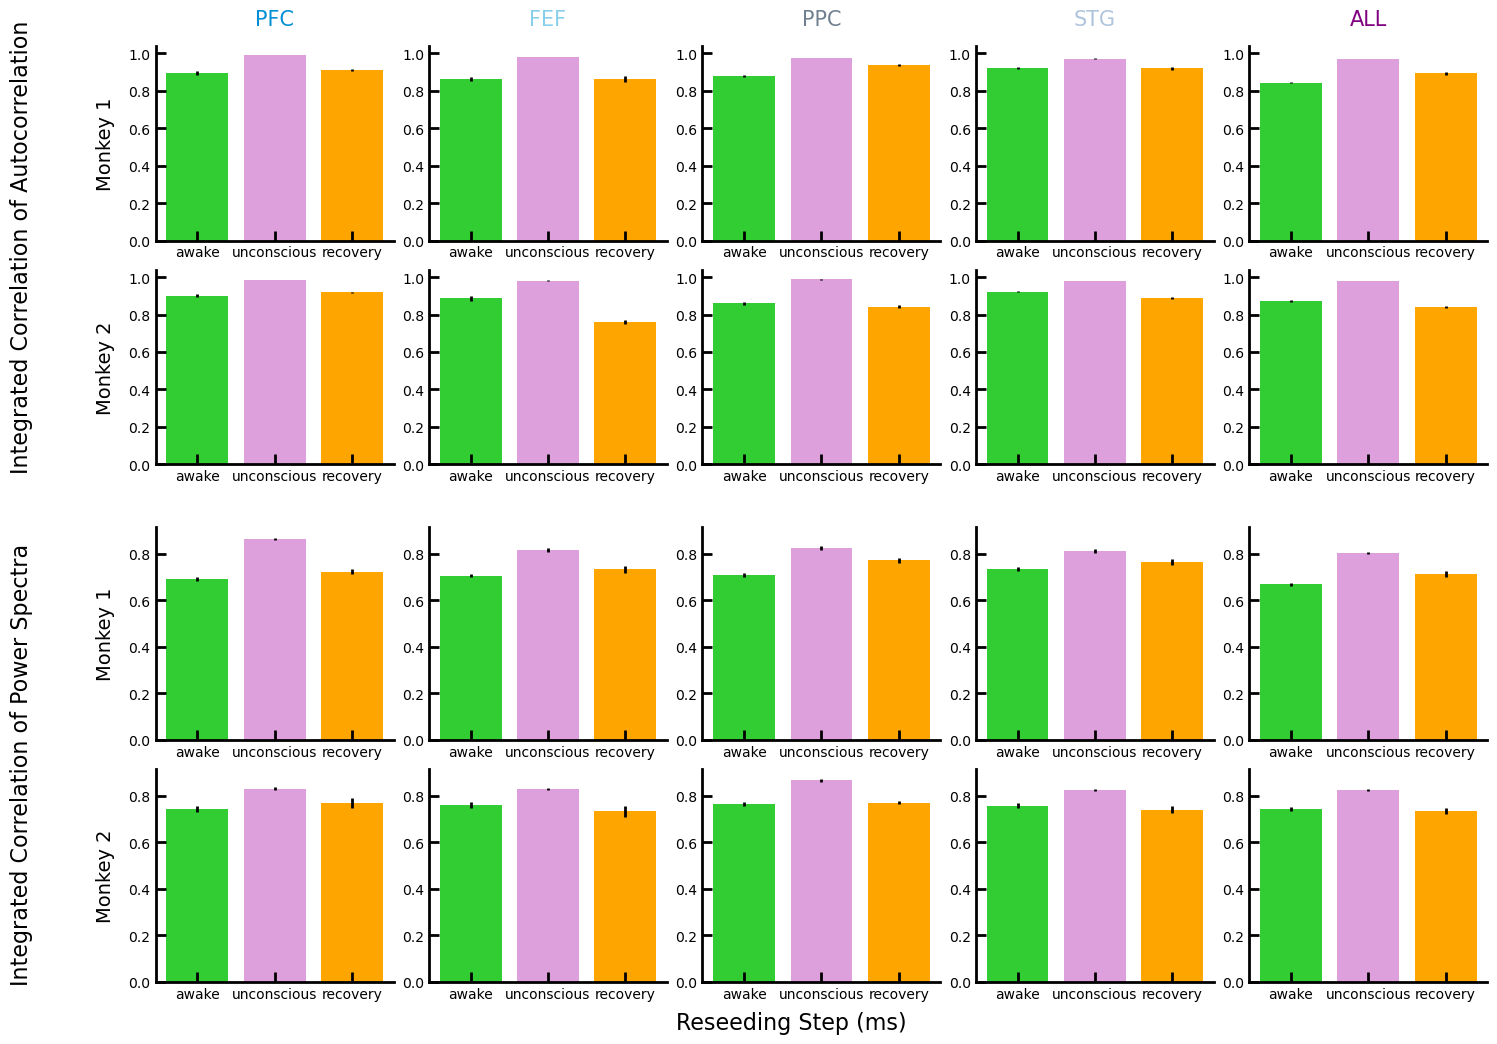

In [207]:
max_reseed = 1000
num_xticks=5
# max_reseed=30
# num_xticks=4
filter_inds = reseed_vals <= max_reseed
title_fontsize = 15
tick_fontsize = 13
xlabel_fontsize=16
ylabel_fontsize=16

fig = plt.figure(layout='constrained', figsize=(14, 10))
subfigs = fig.subfigures(2, 1, hspace=0.07)

axs = subfigs[0].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        for section, _ in section_info:
#             integrated = scipy.integrate.trapezoid(performance_rets[monkey][area][section]['reseed_autocorrel_correl'], reseed_vals/reseed_vals.max())
            integrated = performance_rets_sec[monkey][area][section]['integrated_autocorrel_correl']
            ax.bar(section, integrated, yerr=se_performance_rets[monkey][area][section]['integrated_autocorrel_correl'], color=section_colors[section])
        ax.tick_params(labelsize=tick_fontsize - 3)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if i == 0:
            ax.set_title(area_labels[area], color=area_colors[area], fontsize=title_fontsize)
            
        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)
subfigs[0].text(-0.05, 0.5, 'Integrated Correlation of Autocorrelation', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)
        
axs = subfigs[1].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        for section, _ in section_info:
#             integrated = scipy.integrate.trapezoid(performance_rets[monkey][area][section]['reseed_autocorrel_correl'], reseed_vals/reseed_vals.max())
            integrated = performance_rets_sec[monkey][area][section]['integrated_fft_correl']
            ax.bar(section, integrated, yerr=se_performance_rets[monkey][area][section]['integrated_fft_correl'], color=section_colors[section])
        ax.tick_params(labelsize=tick_fontsize - 3)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)

subfigs[1].text(0.5, -0.05, 'Reseeding Step (ms)', ha='center', fontsize=xlabel_fontsize)
subfigs[1].text(-0.05, 0.5, 'Integrated Correlation of Power Spectra', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)

plt.show()

# Plot 5

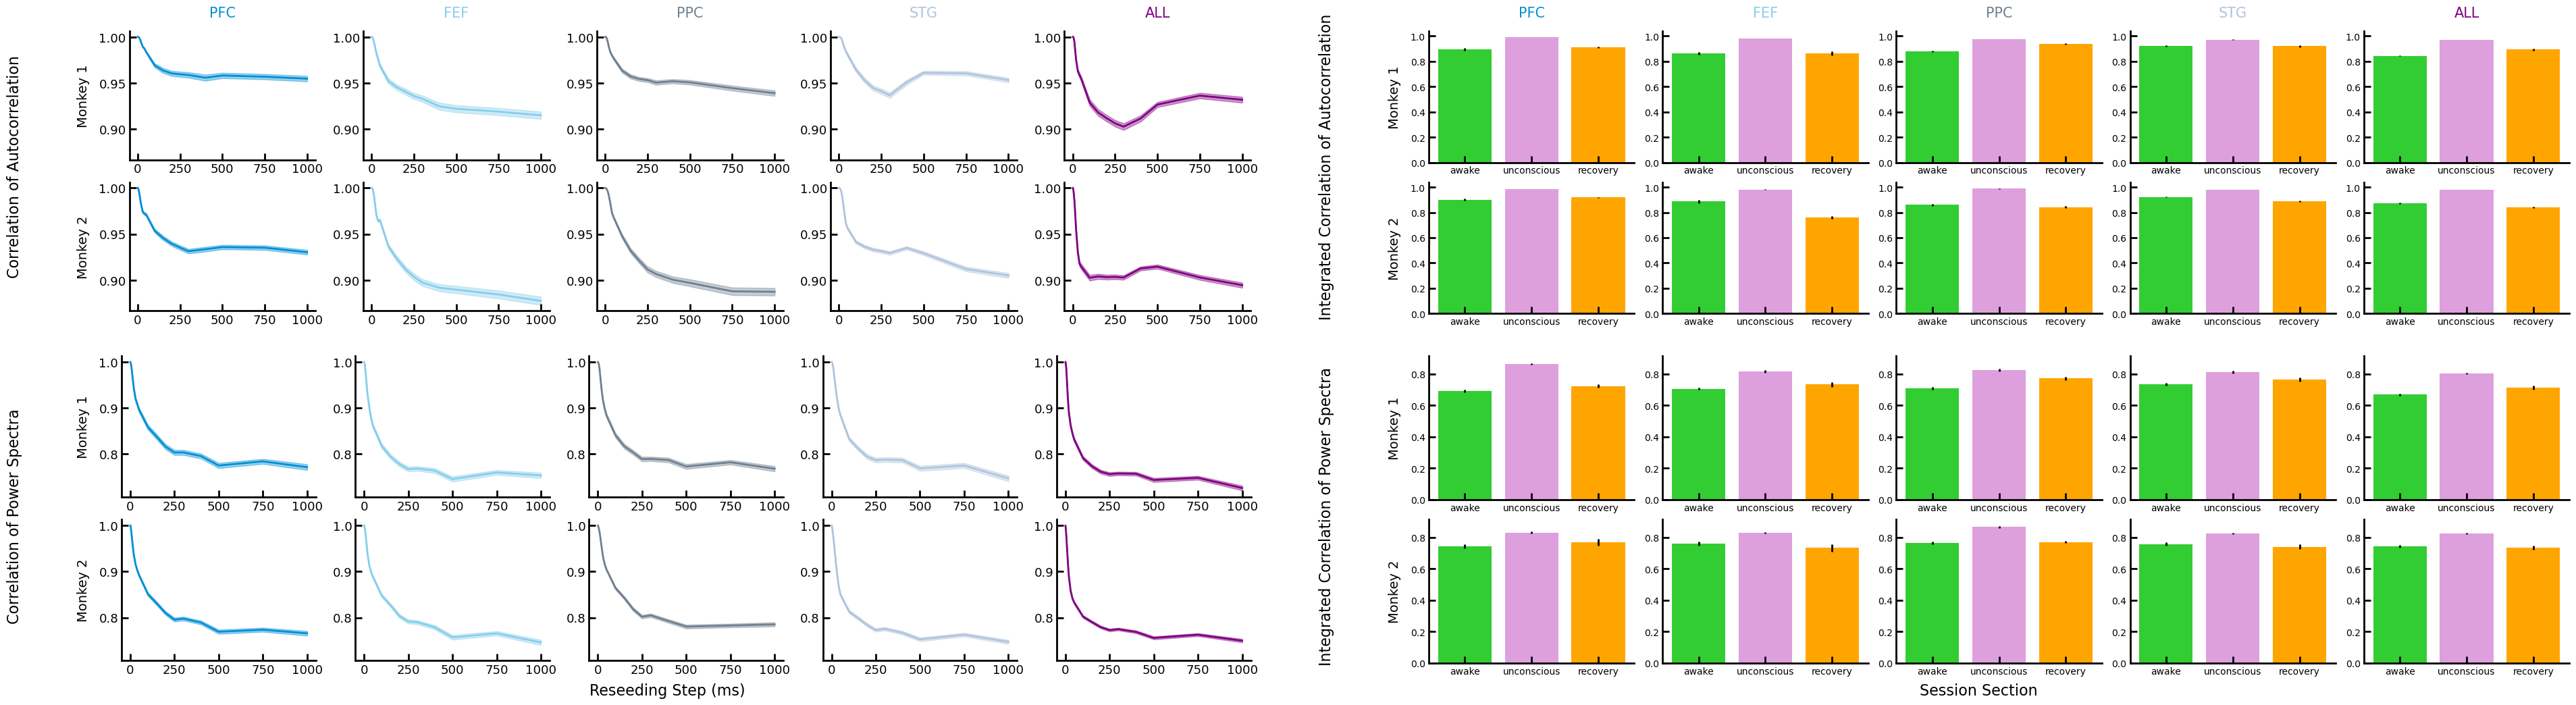

In [217]:
max_reseed = 1000
num_xticks=5
# max_reseed=30
# num_xticks=4
filter_inds = reseed_vals <= max_reseed
title_fontsize = 15
tick_fontsize = 13
xlabel_fontsize=16
ylabel_fontsize=16

bar = False
bar_width=5

fig = plt.figure(layout='constrained', figsize=(37, 10))
subfigs = fig.subfigures(2, 2, hspace=0.07, wspace=0.1)

axs = subfigs[0][0].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        if bar:
            ax.bar(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_autocorrel_correl'][filter_inds], color=area_colors[area], yerr=performance_rets_se[monkey][area]['reseed_autocorrel_correl'][filter_inds], width=bar_width)
        else:
            ax.plot(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_autocorrel_correl'][filter_inds], color=area_colors[area])
            lower_bound = performance_rets[monkey][area]['reseed_autocorrel_correl'] - performance_rets_se[monkey][area]['reseed_autocorrel_correl']
            upper_bound = performance_rets[monkey][area]['reseed_autocorrel_correl'] + performance_rets_se[monkey][area]['reseed_autocorrel_correl']
            ax.fill_between(reseed_vals[filter_inds], lower_bound[filter_inds], upper_bound[filter_inds], alpha=0.4, color=area_colors[area])

        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if i == 0:
            ax.set_title(area_labels[area], color=area_colors[area], fontsize=title_fontsize)
            
        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)
        
        xticks = [int(d) for d in np.linspace(0, max_reseed, num_xticks)]
        ax.set_xticks(xticks)
        ax.tick_params(labelsize=tick_fontsize)

# subfigs[0].text(0.5, -0.01, 'Reseeding Step (ms)', ha='center', fontsize=xlabel_fontsize)
subfigs[0][0].text(-0.05, 0.5, 'Correlation of Autocorrelation', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)

axs = subfigs[1][0].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        if bar:
            ax.bar(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_fft_correl'][filter_inds], color=area_colors[area], yerr=performance_rets_se[monkey][area]['reseed_fft_correl'], width=bar_width)
        else:
            ax.plot(reseed_vals[filter_inds], performance_rets[monkey][area]['reseed_fft_correl'][filter_inds], color=area_colors[area])
            lower_bound = performance_rets[monkey][area]['reseed_fft_correl'] - performance_rets_se[monkey][area]['reseed_fft_correl']
            upper_bound = performance_rets[monkey][area]['reseed_fft_correl'] + performance_rets_se[monkey][area]['reseed_fft_correl']
            ax.fill_between(reseed_vals[filter_inds], lower_bound[filter_inds], upper_bound[filter_inds], alpha=0.4, color=area_colors[area])
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
#         if i == 0:
#             ax.set_title(area_labels[area], color=area_colors[area], fontsize=title_fontsize)

        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)
        
        xticks = [int(d) for d in np.linspace(0, max_reseed, num_xticks)]
        ax.set_xticks(xticks)
        ax.tick_params(labelsize=tick_fontsize)

subfigs[1][0].text(0.5, -0.05, 'Reseeding Step (ms)', ha='center', fontsize=xlabel_fontsize)
subfigs[1][0].text(-0.05, 0.5, 'Correlation of Power Spectra', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)

# plt.tight_layout()

axs = subfigs[0][1].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        for section, _ in section_info:
#             integrated = scipy.integrate.trapezoid(performance_rets[monkey][area][section]['reseed_autocorrel_correl'], reseed_vals/reseed_vals.max())
            integrated = performance_rets_sec[monkey][area][section]['integrated_autocorrel_correl']
            ax.bar(section, integrated, yerr=se_performance_rets[monkey][area][section]['integrated_autocorrel_correl'], color=section_colors[section])
        ax.tick_params(labelsize=tick_fontsize - 3)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if i == 0:
            ax.set_title(area_labels[area], color=area_colors[area], fontsize=title_fontsize)
            
        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)
subfigs[0][1].text(-0.05, 0.5, 'Integrated Correlation of Autocorrelation', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)
        
axs = subfigs[1][1].subplots(2, 5, sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        for section, _ in section_info:
#             integrated = scipy.integrate.trapezoid(performance_rets[monkey][area][section]['reseed_autocorrel_correl'], reseed_vals/reseed_vals.max())
            integrated = performance_rets_sec[monkey][area][section]['integrated_fft_correl']
            ax.bar(section, integrated, yerr=se_performance_rets[monkey][area][section]['integrated_fft_correl'], color=section_colors[section])
        ax.tick_params(labelsize=tick_fontsize - 3)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if j == 0:
            ax.set_ylabel(f"Monkey {i + 1}", fontsize=ylabel_fontsize-2)

subfigs[1][1].text(0.5, -0.05, 'Session Section', ha='center', fontsize=xlabel_fontsize)
subfigs[1][1].text(-0.05, 0.5, 'Integrated Correlation of Power Spectra', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)

plt.show()

# Grid Search Sample

In [222]:
norm_folder = "NOT_NORMED"
for session in tqdm(sessions):
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    # -----------------------------------------
    # LOAD DATA AND DIRECTORY
    # -----------------------------------------
    print("loading data...")
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
    section_times = dict( 
            pre=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            during=(eyes_close, session_info['drugEnd'][1]),
            post=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
#     areas = np.unique(electrode_info['area'])
    # areas = np.hstack([areas, 'all'])
    areas = ['all']
    
    print("data loaded!")
    print("loading directory")
    
    chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
    if len(chunked_folder) == 0:
        print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
    else:
        chunked_folder = chunked_folder[0]

    directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))
    
    print("directory loaded!")
    
    # -----------------------------------------
    # PREP AND QUEUE
    # -----------------------------------------
    
    session_results = {}
    session_results[session] = {}
    # data_processing_df_grid = deepcopy(mp_args.data_processing_df)

    grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
    areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

    for area in areas:
        df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
        for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
            t = float(f.split('_')[0])
            file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
            df_new = pd.DataFrame(pd.read_pickle(file_path))
            if np.isnan(df_new.AIC).sum() > 0:
                print(file_path)
            df_new = df_new.set_index(['window', 'matrix_size', 'r'])
            for i, row in df_new.iterrows():
                if i in df.index:
                    df.loc[i, 'AICs'].append(row.AIC)
                    df.loc[i, 'time_vals'].append(t)
                    df.loc[i, 'file_paths'].append(file_path)
                else:
                    df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

        df = df.loc[df.index.sortlevel()[0]]
        session_results[session][area] = df
    
    print("Grid search results loaded!")
    
    raise ValueError

  0%|          | 0/2 [00:00<?, ?it/s]

------------------------------
SESSION = MrJones-Anesthesia-20160301-01
------------------------------
loading data...
data loaded!
loading directory
directory loaded!
Grid search results loaded!


ValueError: 

In [232]:
session_results[session][area]

AICs  \
window matrix_size r                                                         
15000  50          3     [-7.590334834116814, -7.603868574776558, -7.22...   
                   5     [-7.754876962387713, -7.764571443231806, -7.64...   
                   10    [-8.094651357176897, -8.08541925218533, -8.127...   
                   25    [-8.85641070967006, -8.790768731903526, -9.171...   
                   50    [-9.950864984066863, -9.809018075704513, -10.8...   
...                                                                    ...   
       1500        800   [-9.802388211722835, -9.175762344395187, -9.27...   
                   900   [-9.79178155694421, -9.140794152234218, -9.252...   
                   1000  [-9.89084283165408, -9.214167717525344, -9.327...   
                   1200  [-10.2817162920229, -9.593067989587714, -9.708...   
                   1400  [-10.550518915038724, -9.827726007449328, -9.9...   

                                                                 time_vals  \
window matrix_size r                                                         
15000  50          3     [1176.365, 2288.55, 4418.763, 3716.331, 6771.8...   
                   5     [1176.365, 2288.55, 4418.763, 3716.331, 6771.8...   
                   10    [1176.365, 2288.55, 4418.763, 3716.331, 6771.8...   
                   25    [1176.365, 2288.55, 4418.763, 3716.331, 6771.8...   
                   50    [1176.365, 2288.55, 4418.763, 3716.331, 6771.8...   
...                                                                    ...   
       1500        800   [4802.199, 9123.291, 6771.852, 1300.445, 2288....   
                   900   [4802.199, 9123.291, 6771.852, 1300.445, 2288....   
                   1000  [4802.199, 9123.291, 6771.852, 1300.445, 2288....   
                   1200  [4802.199, 9123.291, 6771.852, 1300.445, 2288....   
                   1400  [4802.199, 9123.291, 6771.852, 1300.445, 2288....   

                                                                file_paths  
window matrix_size r                                                        
15000  50          3     [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   5     [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   10    [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   25    [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   50    [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
...                                                                    ...  
       1500        800   [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   900   [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   1000  [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   1200  [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  
                   1400  [/scratch2/weka/millerlab/eisenaj/ChaoticConsc...  

[169 rows x 3 columns]

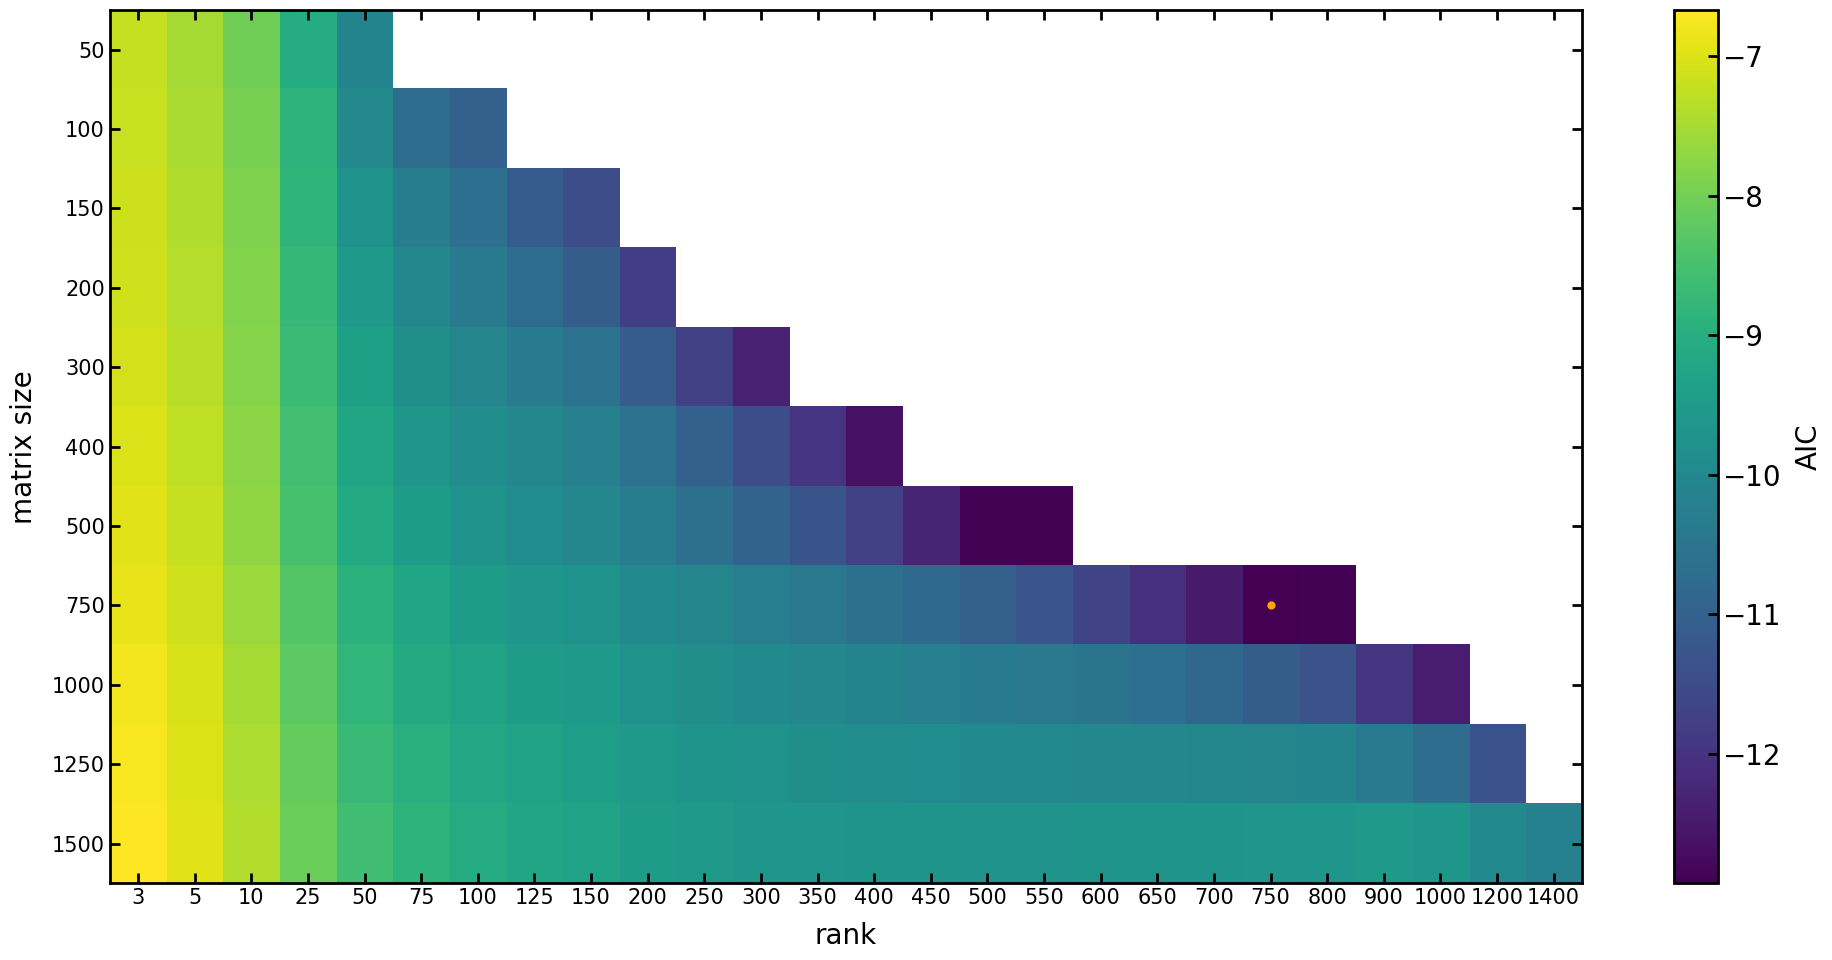

In [240]:
plot_AIC({area: session_results[session][area] for area in areas if area != 'all'}, figsize=(20, 10))